In [1]:
import tensorflow as tf
import gym
from IPython.display import clear_output
import time
import numpy as np

In [2]:
env=gym.make('Alien-v0')
obs=env.reset()
print(env.action_space)

Discrete(18)


In [3]:
from PIL import Image
resize_x=64
resize_y=64
def preprocessing(obs):
    buf=[]
    for i in range(len(obs)):
        xbuf=[]
        for j in range(len(obs[i])):
            gray_pixel=obs[i][j][0]*0.299+obs[i][j][1]+0.587+obs[i][j][2]*0.114
            xbuf.append(gray_pixel)
        buf.append(xbuf)
    #return np.array(buf)
    nparr=np.array(buf)
    image=Image.fromarray(nparr).resize((resize_x,resize_y))
    return np.array(image)#image
          
def inqueue(queue,obs,que_size):
    queue.append(obs)
    if len(queue)>4:
        queue.pop(0)
    return queue
#test code

In [4]:

score=0
step=0
rewards=[]
frame_queue=[]
queue_size=4


score>190.0	step>970


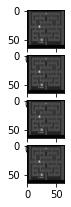

In [4]:
#Random Agent
score=0
step=0
rewards=[]
frame_queue=[]
queue_size=4

while True:
    action=env.action_space.sample()
    obs,reward,done,info=env.step(action)
    env.render()
    frame_queue=inqueue(frame_queue,obs,queue_size)
    
    score+=reward
    rewards.append(reward)
    step+=1
    if done:
        break

print(f'score>{score}\tstep>{step}')

import matplotlib.pyplot as plt
for i in range(len(frame_queue)):
    
    plt.subplot(len(frame_queue)+1,1,i+1)
    plt.imshow(np.asarray(frame_queue[0]),cmap='gray')
plt.show()

In [5]:
def xyz2zxy(xyzArray):
    zxyArray=np.zeros((len(xyzArray[0]),len(xyzArray[0][0]),len(xyzArray)))
    for i in range(len(xyzArray)):
        for j in range(len(xyzArray[i])):
            for k in range(len(xyzArray[i][j])):
                zxyArray[j][k][i]=xyzArray[i][j][k]
    return zxyArray
def buildmodel():
    model=tf.keras.Sequential([
            tf.keras.layers.Conv2D(input_shape=(resize_x,resize_y,queue_size,), kernel_size=(8,8), filters=16),
            tf.keras.layers.MaxPool2D(strides=(2,2)),
            tf.keras.layers.Conv2D(kernel_size=(4,4),filters=32),
            tf.keras.layers.MaxPool2D(strides=(2,2)),
            tf.keras.layers.Conv2D(kernel_size=(4,4),filters=32),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=256, activation='relu'),
            tf.keras.layers.Dense(units=18, activation='softmax')
        ])
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
model=buildmodel()
target_model=buildmodel()
model.summary()
target_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 16)        4112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          16416     
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [6]:
gamma=0.9
batch_size=512
max_memory=batch_size*16
memory=[]

def append_sample(mem,state,action,reward,next_state,done):
    mem.append([state,action,reward,next_state,done])
    
def train_model(c_model,t_model):
    np.random.shuffle(memory)
    lenth=max_memory//batch_size
    for i in length:
        mini_batch=memory[k*batch_size:(k+1)*batch_size]
        states=np.zeros((batch_size,resize_x,resize_y,queue_size))
        next_states=np.zeros((batch_size,resize_x,resize_y,queue_size))
        actions,rewards,dones=[],[],[]
        
        
        for i in range(batch_size):
            states[i]=mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i]=mini_batch[i][3]
            dones.append(mini_batch[i][4])
            
        target=c_model.predict(states)
        next_target=t_model.predict(next_states)
        
        for i in range(batch_size):
            if dones[i]:
                target[i][actions[i]]=rewards[i]
            else:
                target[i][actions[i]]=rewards[i]+gamma*np.amax(next_target[i])
        model.fit(states,target,batch_size=batch_size,epochs=2,verbose=0)

In [11]:
import random
import math 

def softmax(logits):
    exp_logits=np.exp(logits-np.max(logits))
    sum_exp_logits=np.sum(exp_logits)
    return exp_logits/sum_exp_logits
max_episodes=11
epsilon=0.9
epsilon_min=0.1

scores=[]
steps=[]
iteration=0
train_count=0
print(env._max_episode_steps)
for i in range(max_episodes):
    #if i%100==1 and i!=0:
        #print(f'{i}\tscore mean>{np.mean(scores[-100:])}\tstep mean>{np.mean(steps[-100:])}\titeration>{iteration}\tepsilon>{epsilon}')
    print(f'{i}\tscore mean>{np.mean(scores[-100:])}\tstep mean>{np.mean(steps[-100:])}\titeration>{iteration}\tepsilon>{epsilon}')
    prev_obs=preprocessing(env.reset())
    score=0
    step=0
    
    
    while step<env._max_episode_steps/10:
        iteration+=1
        if random.random()<epsilon and len(frame_queue)<4:
            action=env.action_space.sample()
        else:
            x=prev_obs
            val=np.expand_dims(xyz2zxy(frame_queue),axis=0)
            logits=model.predict(val)
            prob=softmax(logits)
            action=np.argmax(prob)
        obs,reward,done,info=env.step([action])
        processing_obs=preprocessing(obs)
        frame_queue=inqueue(frame_queue,processing_obs,queue_size)
        score+=reward
        step+=1
        
        print(f'step>{step}\treward>{reward}')
        #custom reward
        append_sample(memory,prev_obs,action,reward,processing_obs,done)
        
        if len(memory)>=max_memory:
            train_model(model,target_model)
            memory=[]
            train_count+=1
            if train_count%4==0:
                target_model.set_weights(model.get_weights())
        prev_obs=processing_obs
        if epsilon>0.01 and iteration%2500==0:
            epsilon=epsilon/1.005
        if done:
            break
    scores.append(score)
    steps.append(step)
    print(f'{i}\tScore>{score}\tStep>{step}\tMax_tile>{np.max(obs)}\tmemory_len>{len(memory)}')
        

10000
0	score mean>nan	step mean>nan	iteration>0	epsilon>0.9
step>1	reward>0.0
step>2	reward>0.0
step>3	reward>0.0
step>4	reward>0.0
step>5	reward>0.0
step>6	reward>0.0
step>7	reward>0.0
step>8	reward>0.0
step>9	reward>0.0
step>10	reward>0.0
step>11	reward>0.0
step>12	reward>0.0
step>13	reward>0.0
step>14	reward>0.0
step>15	reward>0.0
step>16	reward>0.0
step>17	reward>0.0
step>18	reward>0.0
step>19	reward>0.0
step>20	reward>0.0
step>21	reward>0.0
step>22	reward>0.0
step>23	reward>0.0
step>24	reward>0.0
step>25	reward>0.0
step>26	reward>0.0
step>27	reward>0.0
step>28	reward>0.0
step>29	reward>0.0
step>30	reward>0.0
step>31	reward>0.0
step>32	reward>0.0
step>33	reward>0.0
step>34	reward>0.0
step>35	reward>0.0
step>36	reward>0.0
step>37	reward>0.0
step>38	reward>0.0
step>39	reward>0.0
step>40	reward>0.0
step>41	reward>0.0
step>42	reward>0.0
step>43	reward>0.0
step>44	reward>0.0
step>45	reward>0.0
step>46	reward>0.0
step>47	reward>0.0
step>48	reward>0.0
step>49	reward>0.0
step>50	reward>0.

step>413	reward>0.0
step>414	reward>0.0
step>415	reward>0.0
step>416	reward>0.0
step>417	reward>0.0
step>418	reward>0.0
step>419	reward>0.0
step>420	reward>0.0
step>421	reward>0.0
step>422	reward>0.0
step>423	reward>0.0
step>424	reward>0.0
step>425	reward>0.0
step>426	reward>0.0
step>427	reward>0.0
step>428	reward>0.0
step>429	reward>0.0
step>430	reward>0.0
step>431	reward>0.0
step>432	reward>0.0
step>433	reward>0.0
step>434	reward>0.0
step>435	reward>0.0
step>436	reward>0.0
step>437	reward>0.0
step>438	reward>0.0
step>439	reward>0.0
step>440	reward>0.0
step>441	reward>0.0
step>442	reward>0.0
step>443	reward>0.0
step>444	reward>0.0
step>445	reward>0.0
step>446	reward>0.0
step>447	reward>0.0
step>448	reward>0.0
step>449	reward>0.0
step>450	reward>0.0
step>451	reward>0.0
step>452	reward>0.0
step>453	reward>0.0
step>454	reward>0.0
step>455	reward>0.0
step>456	reward>0.0
step>457	reward>0.0
step>458	reward>0.0
step>459	reward>0.0
step>460	reward>0.0
step>461	reward>0.0
step>462	reward>0.0


step>250	reward>0.0
step>251	reward>0.0
step>252	reward>0.0
step>253	reward>0.0
step>254	reward>0.0
step>255	reward>0.0
step>256	reward>0.0
step>257	reward>0.0
step>258	reward>0.0
step>259	reward>0.0
step>260	reward>0.0
step>261	reward>0.0
step>262	reward>0.0
step>263	reward>0.0
step>264	reward>0.0
step>265	reward>0.0
step>266	reward>0.0
step>267	reward>0.0
step>268	reward>0.0
step>269	reward>0.0
step>270	reward>0.0
step>271	reward>0.0
step>272	reward>0.0
step>273	reward>0.0
step>274	reward>0.0
step>275	reward>0.0
step>276	reward>0.0
step>277	reward>0.0
step>278	reward>0.0
step>279	reward>0.0
step>280	reward>0.0
step>281	reward>0.0
step>282	reward>0.0
step>283	reward>0.0
step>284	reward>0.0
step>285	reward>0.0
step>286	reward>0.0
step>287	reward>0.0
step>288	reward>0.0
step>289	reward>0.0
step>290	reward>0.0
step>291	reward>0.0
step>292	reward>0.0
step>293	reward>0.0
step>294	reward>0.0
step>295	reward>0.0
step>296	reward>0.0
step>297	reward>0.0
step>298	reward>0.0
step>299	reward>0.0


step>100	reward>0.0
step>101	reward>0.0
step>102	reward>0.0
step>103	reward>0.0
step>104	reward>0.0
step>105	reward>0.0
step>106	reward>0.0
step>107	reward>0.0
step>108	reward>0.0
step>109	reward>0.0
step>110	reward>0.0
step>111	reward>0.0
step>112	reward>0.0
step>113	reward>0.0
step>114	reward>0.0
step>115	reward>0.0
step>116	reward>0.0
step>117	reward>0.0
step>118	reward>0.0
step>119	reward>0.0
step>120	reward>0.0
step>121	reward>0.0
step>122	reward>0.0
step>123	reward>0.0
step>124	reward>0.0
step>125	reward>0.0
step>126	reward>0.0
step>127	reward>0.0
step>128	reward>0.0
step>129	reward>0.0
step>130	reward>0.0
step>131	reward>0.0
step>132	reward>0.0
step>133	reward>0.0
step>134	reward>0.0
step>135	reward>0.0
step>136	reward>0.0
step>137	reward>0.0
step>138	reward>0.0
step>139	reward>0.0
step>140	reward>0.0
step>141	reward>0.0
step>142	reward>0.0
step>143	reward>0.0
step>144	reward>0.0
step>145	reward>0.0
step>146	reward>0.0
step>147	reward>0.0
step>148	reward>0.0
step>149	reward>0.0


step>510	reward>0.0
step>511	reward>0.0
step>512	reward>0.0
step>513	reward>0.0
step>514	reward>0.0
step>515	reward>0.0
step>516	reward>0.0
step>517	reward>0.0
step>518	reward>0.0
step>519	reward>0.0
step>520	reward>0.0
step>521	reward>0.0
step>522	reward>0.0
step>523	reward>0.0
step>524	reward>0.0
step>525	reward>0.0
step>526	reward>0.0
step>527	reward>0.0
step>528	reward>0.0
step>529	reward>0.0
step>530	reward>0.0
step>531	reward>0.0
step>532	reward>0.0
step>533	reward>0.0
step>534	reward>0.0
step>535	reward>0.0
step>536	reward>0.0
step>537	reward>0.0
step>538	reward>0.0
step>539	reward>0.0
step>540	reward>0.0
step>541	reward>0.0
step>542	reward>0.0
step>543	reward>0.0
2	Score>0.0	Step>543	Max_tile>252	memory_len>1679
3	score mean>20.0	step mean>558.6666666666666	iteration>1676	epsilon>0.9
step>1	reward>0.0
step>2	reward>0.0
step>3	reward>0.0
step>4	reward>0.0
step>5	reward>0.0
step>6	reward>0.0
step>7	reward>0.0
step>8	reward>0.0
step>9	reward>0.0
step>10	reward>0.0
step>11	reward>0

step>376	reward>0.0
step>377	reward>0.0
step>378	reward>0.0
step>379	reward>0.0
step>380	reward>0.0
step>381	reward>0.0
step>382	reward>0.0
step>383	reward>0.0
step>384	reward>0.0
step>385	reward>0.0
step>386	reward>0.0
step>387	reward>0.0
step>388	reward>0.0
step>389	reward>0.0
step>390	reward>0.0
step>391	reward>0.0
step>392	reward>0.0
step>393	reward>0.0
step>394	reward>0.0
step>395	reward>0.0
step>396	reward>0.0
step>397	reward>0.0
step>398	reward>0.0
step>399	reward>0.0
step>400	reward>0.0
step>401	reward>0.0
step>402	reward>0.0
step>403	reward>0.0
step>404	reward>0.0
step>405	reward>0.0
step>406	reward>0.0
step>407	reward>0.0
step>408	reward>0.0
step>409	reward>0.0
step>410	reward>0.0
step>411	reward>0.0
step>412	reward>0.0
step>413	reward>0.0
step>414	reward>0.0
step>415	reward>0.0
step>416	reward>0.0
step>417	reward>0.0
step>418	reward>0.0
step>419	reward>0.0
step>420	reward>0.0
step>421	reward>0.0
step>422	reward>0.0
step>423	reward>0.0
step>424	reward>0.0
step>425	reward>0.0


step>225	reward>0.0
step>226	reward>0.0
step>227	reward>0.0
step>228	reward>0.0
step>229	reward>0.0
step>230	reward>0.0
step>231	reward>0.0
step>232	reward>0.0
step>233	reward>0.0
step>234	reward>0.0
step>235	reward>0.0
step>236	reward>0.0
step>237	reward>0.0
step>238	reward>0.0
step>239	reward>0.0
step>240	reward>0.0
step>241	reward>0.0
step>242	reward>0.0
step>243	reward>0.0
step>244	reward>0.0
step>245	reward>0.0
step>246	reward>0.0
step>247	reward>0.0
step>248	reward>0.0
step>249	reward>0.0
step>250	reward>0.0
step>251	reward>0.0
step>252	reward>0.0
step>253	reward>0.0
step>254	reward>0.0
step>255	reward>0.0
step>256	reward>0.0
step>257	reward>0.0
step>258	reward>0.0
step>259	reward>0.0
step>260	reward>0.0
step>261	reward>0.0
step>262	reward>0.0
step>263	reward>0.0
step>264	reward>0.0
step>265	reward>0.0
step>266	reward>0.0
step>267	reward>0.0
step>268	reward>0.0
step>269	reward>0.0
step>270	reward>0.0
step>271	reward>0.0
step>272	reward>0.0
step>273	reward>0.0
step>274	reward>0.0


step>67	reward>0.0
step>68	reward>0.0
step>69	reward>0.0
step>70	reward>0.0
step>71	reward>0.0
step>72	reward>0.0
step>73	reward>0.0
step>74	reward>0.0
step>75	reward>0.0
step>76	reward>0.0
step>77	reward>0.0
step>78	reward>0.0
step>79	reward>0.0
step>80	reward>0.0
step>81	reward>0.0
step>82	reward>0.0
step>83	reward>0.0
step>84	reward>0.0
step>85	reward>0.0
step>86	reward>0.0
step>87	reward>0.0
step>88	reward>0.0
step>89	reward>0.0
step>90	reward>0.0
step>91	reward>0.0
step>92	reward>0.0
step>93	reward>0.0
step>94	reward>0.0
step>95	reward>0.0
step>96	reward>0.0
step>97	reward>0.0
step>98	reward>0.0
step>99	reward>0.0
step>100	reward>0.0
step>101	reward>0.0
step>102	reward>0.0
step>103	reward>0.0
step>104	reward>0.0
step>105	reward>0.0
step>106	reward>0.0
step>107	reward>0.0
step>108	reward>0.0
step>109	reward>0.0
step>110	reward>0.0
step>111	reward>0.0
step>112	reward>0.0
step>113	reward>0.0
step>114	reward>0.0
step>115	reward>0.0
step>116	reward>0.0
step>117	reward>0.0
step>118	rewa

step>479	reward>0.0
step>480	reward>0.0
step>481	reward>0.0
step>482	reward>0.0
step>483	reward>0.0
step>484	reward>0.0
step>485	reward>0.0
step>486	reward>0.0
step>487	reward>0.0
step>488	reward>0.0
step>489	reward>0.0
step>490	reward>0.0
step>491	reward>0.0
step>492	reward>0.0
step>493	reward>0.0
step>494	reward>0.0
step>495	reward>0.0
step>496	reward>0.0
step>497	reward>0.0
step>498	reward>0.0
step>499	reward>0.0
step>500	reward>0.0
step>501	reward>0.0
step>502	reward>0.0
step>503	reward>0.0
step>504	reward>0.0
step>505	reward>0.0
step>506	reward>0.0
step>507	reward>0.0
step>508	reward>0.0
step>509	reward>0.0
step>510	reward>0.0
step>511	reward>0.0
step>512	reward>0.0
step>513	reward>0.0
step>514	reward>0.0
step>515	reward>0.0
step>516	reward>0.0
step>517	reward>0.0
step>518	reward>0.0
step>519	reward>0.0
step>520	reward>0.0
step>521	reward>0.0
step>522	reward>0.0
step>523	reward>0.0
step>524	reward>0.0
step>525	reward>0.0
step>526	reward>0.0
step>527	reward>0.0
step>528	reward>0.0


step>340	reward>0.0
step>341	reward>0.0
step>342	reward>0.0
step>343	reward>0.0
step>344	reward>0.0
step>345	reward>0.0
step>346	reward>0.0
step>347	reward>0.0
step>348	reward>0.0
step>349	reward>0.0
step>350	reward>0.0
step>351	reward>0.0
step>352	reward>0.0
step>353	reward>0.0
step>354	reward>0.0
step>355	reward>0.0
step>356	reward>0.0
step>357	reward>0.0
step>358	reward>0.0
step>359	reward>0.0
step>360	reward>0.0
step>361	reward>0.0
step>362	reward>0.0
step>363	reward>0.0
step>364	reward>0.0
step>365	reward>0.0
step>366	reward>0.0
step>367	reward>0.0
step>368	reward>0.0
step>369	reward>0.0
step>370	reward>0.0
step>371	reward>0.0
step>372	reward>0.0
step>373	reward>0.0
step>374	reward>0.0
step>375	reward>0.0
step>376	reward>0.0
step>377	reward>0.0
step>378	reward>0.0
step>379	reward>0.0
step>380	reward>0.0
step>381	reward>0.0
step>382	reward>0.0
step>383	reward>0.0
step>384	reward>0.0
step>385	reward>0.0
step>386	reward>0.0
step>387	reward>0.0
step>388	reward>0.0
step>389	reward>0.0


step>192	reward>0.0
step>193	reward>0.0
step>194	reward>0.0
step>195	reward>0.0
step>196	reward>0.0
step>197	reward>0.0
step>198	reward>0.0
step>199	reward>0.0
step>200	reward>0.0
step>201	reward>0.0
step>202	reward>0.0
step>203	reward>0.0
step>204	reward>0.0
step>205	reward>0.0
step>206	reward>0.0
step>207	reward>0.0
step>208	reward>0.0
step>209	reward>0.0
step>210	reward>0.0
step>211	reward>0.0
step>212	reward>0.0
step>213	reward>0.0
step>214	reward>0.0
step>215	reward>0.0
step>216	reward>0.0
step>217	reward>0.0
step>218	reward>0.0
step>219	reward>0.0
step>220	reward>0.0
step>221	reward>0.0
step>222	reward>0.0
step>223	reward>0.0
step>224	reward>0.0
step>225	reward>0.0
step>226	reward>0.0
step>227	reward>0.0
step>228	reward>0.0
step>229	reward>0.0
step>230	reward>0.0
step>231	reward>0.0
step>232	reward>0.0
step>233	reward>0.0
step>234	reward>0.0
step>235	reward>0.0
step>236	reward>0.0
step>237	reward>0.0
step>238	reward>0.0
step>239	reward>0.0
step>240	reward>0.0
step>241	reward>0.0


step>32	reward>0.0
step>33	reward>0.0
step>34	reward>0.0
step>35	reward>0.0
step>36	reward>0.0
step>37	reward>0.0
step>38	reward>0.0
step>39	reward>0.0
step>40	reward>0.0
step>41	reward>0.0
step>42	reward>0.0
step>43	reward>0.0
step>44	reward>0.0
step>45	reward>0.0
step>46	reward>0.0
step>47	reward>0.0
step>48	reward>0.0
step>49	reward>0.0
step>50	reward>0.0
step>51	reward>0.0
step>52	reward>0.0
step>53	reward>0.0
step>54	reward>0.0
step>55	reward>0.0
step>56	reward>0.0
step>57	reward>0.0
step>58	reward>0.0
step>59	reward>0.0
step>60	reward>0.0
step>61	reward>0.0
step>62	reward>0.0
step>63	reward>0.0
step>64	reward>0.0
step>65	reward>0.0
step>66	reward>0.0
step>67	reward>0.0
step>68	reward>0.0
step>69	reward>0.0
step>70	reward>0.0
step>71	reward>0.0
step>72	reward>0.0
step>73	reward>0.0
step>74	reward>0.0
step>75	reward>0.0
step>76	reward>0.0
step>77	reward>0.0
step>78	reward>0.0
step>79	reward>0.0
step>80	reward>0.0
step>81	reward>0.0
step>82	reward>0.0
step>83	reward>0.0
step>84	rewa

step>446	reward>0.0
step>447	reward>0.0
step>448	reward>0.0
step>449	reward>0.0
step>450	reward>0.0
step>451	reward>0.0
step>452	reward>0.0
step>453	reward>0.0
step>454	reward>0.0
step>455	reward>0.0
step>456	reward>0.0
step>457	reward>0.0
step>458	reward>0.0
step>459	reward>0.0
step>460	reward>0.0
step>461	reward>0.0
step>462	reward>0.0
step>463	reward>0.0
step>464	reward>0.0
step>465	reward>0.0
step>466	reward>0.0
step>467	reward>0.0
step>468	reward>0.0
step>469	reward>0.0
step>470	reward>0.0
step>471	reward>0.0
step>472	reward>0.0
step>473	reward>0.0
step>474	reward>0.0
step>475	reward>0.0
step>476	reward>0.0
step>477	reward>0.0
step>478	reward>0.0
step>479	reward>0.0
step>480	reward>0.0
step>481	reward>0.0
step>482	reward>0.0
step>483	reward>0.0
step>484	reward>0.0
step>485	reward>0.0
step>486	reward>0.0
step>487	reward>0.0
step>488	reward>0.0
step>489	reward>0.0
step>490	reward>0.0
step>491	reward>0.0
step>492	reward>0.0
step>493	reward>0.0
step>494	reward>0.0
step>495	reward>0.0


step>313	reward>0.0
step>314	reward>0.0
step>315	reward>0.0
step>316	reward>0.0
step>317	reward>0.0
step>318	reward>0.0
step>319	reward>0.0
step>320	reward>0.0
step>321	reward>0.0
step>322	reward>0.0
step>323	reward>0.0
step>324	reward>0.0
step>325	reward>0.0
step>326	reward>0.0
step>327	reward>0.0
step>328	reward>0.0
step>329	reward>0.0
step>330	reward>0.0
step>331	reward>0.0
step>332	reward>0.0
step>333	reward>0.0
step>334	reward>0.0
step>335	reward>0.0
step>336	reward>0.0
step>337	reward>0.0
step>338	reward>0.0
step>339	reward>0.0
step>340	reward>0.0
step>341	reward>0.0
step>342	reward>0.0
step>343	reward>0.0
step>344	reward>0.0
step>345	reward>0.0
step>346	reward>0.0
step>347	reward>0.0
step>348	reward>0.0
step>349	reward>0.0
step>350	reward>0.0
step>351	reward>0.0
step>352	reward>0.0
step>353	reward>0.0
step>354	reward>0.0
step>355	reward>0.0
step>356	reward>0.0
step>357	reward>0.0
step>358	reward>0.0
step>359	reward>0.0
step>360	reward>0.0
step>361	reward>0.0
step>362	reward>0.0


step>172	reward>0.0
step>173	reward>0.0
step>174	reward>0.0
step>175	reward>0.0
step>176	reward>0.0
step>177	reward>0.0
step>178	reward>0.0
step>179	reward>0.0
step>180	reward>0.0
step>181	reward>0.0
step>182	reward>0.0
step>183	reward>0.0
step>184	reward>0.0
step>185	reward>0.0
step>186	reward>0.0
step>187	reward>0.0
step>188	reward>0.0
step>189	reward>0.0
step>190	reward>0.0
step>191	reward>0.0
step>192	reward>0.0
step>193	reward>0.0
step>194	reward>0.0
step>195	reward>0.0
step>196	reward>0.0
step>197	reward>0.0
step>198	reward>0.0
step>199	reward>0.0
step>200	reward>0.0
step>201	reward>0.0
step>202	reward>0.0
step>203	reward>0.0
step>204	reward>0.0
step>205	reward>0.0
step>206	reward>0.0
step>207	reward>0.0
step>208	reward>0.0
step>209	reward>0.0
step>210	reward>0.0
step>211	reward>0.0
step>212	reward>0.0
step>213	reward>0.0
step>214	reward>0.0
step>215	reward>0.0
step>216	reward>0.0
step>217	reward>0.0
step>218	reward>0.0
step>219	reward>0.0
step>220	reward>0.0
step>221	reward>0.0


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

pix_size=10
max_len=int(len(obs)/pix_size*len(obs[i])/pix_size)
for i in range(int(len(obs)/pix_size)):
    for j in range(int(len(obs[i])/pix_size)):
        idx=i*21+j+1
        if idx > max_len:
            break
        buf=[]
        for k in range(pix_size):
            xbuf=[]
            for l in range(pix_size):
                xbuf.append(obs[i*10+k][j*10+l])
            buf.append(xbuf)
        
        plt.subplot(21,16,idx,label=np.mean(buf))
        plt.imshow(buf)
    
plt.show()

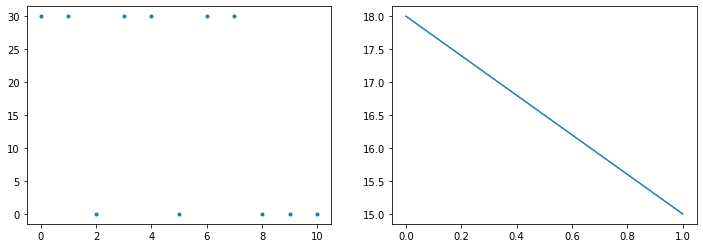

In [14]:
import matplotlib.pyplot as plt
N=10
rolling_mean=[np.mean(scores[x:x+N]) for x in range(len(scores)-N+1)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores)),scores,marker='.')
plt.subplot(1,2,2)
plt.plot(rolling_mean)
plt.show()

[[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 12], [array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(30000, 210, 160, 3)
(30000, 1)


Epoch 1/30
1407/1407 [==============================] - 83s 59ms/step - loss: 8.6856 - accuracy: 0.0557 - val_loss: 2.8903 - val_accuracy: 0.0589
Epoch 2/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0555 - val_loss: 2.8902 - val_accuracy: 0.0589
Epoch 3/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0561 - val_loss: 2.8902 - val_accuracy: 0.0589
Epoch 4/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0570 - val_loss: 2.8904 - val_accuracy: 0.0588
Epoch 5/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0563 - val_loss: 2.8904 - val_accuracy: 0.0588
Epoch 6/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0576 - val_loss: 2.8905 - val_accuracy: 0.0588
Epoch 7/30
1407/1407 [==============================] - 83s 59ms/step - loss: 2.8904 - accuracy: 0.0565 - val_loss: 2.8903 -